## SOMMAIRE <span id='som'>
   
- [Mission 3 ](#m3)
    - [Y a-t-il une corrélation entre le sexe des clients et les catégories de produits achetés ?](#q1)
    - [Y a-t-il une corrélation entre l'âge des clients et :](#q2)
        - [le montant total des achats](#q2)
        - [la fréquence d’achat (ie. nombre d'achats par mois par exemple)](#q3)
        - [la taille du panier moyen (en nombre d’articles)](#q4)
        - [les catégories de produits achetés](#q5)
        - [bonus](#bonus)

In [1]:
import pandas as pd
import numpy as np
from os import getcwd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import calendar
import scipy.stats as ss
from scipy.stats import norm
from scipy.stats import kurtosis, skew
from scipy.stats import linregress
import matplotlib.ticker as ticker
from scipy.stats import chi2_contingency
from sklearn.linear_model import LinearRegression

In [2]:
data = pd.read_csv("../sales/data_values_clear/merge.csv", parse_dates=True)
data.head(1)

,index,client_id,sex,user_birthday,binning_age,user_age,category_id,id_product,price,sell_date,transaction_date,sell_year,month,month_string,traceability_transaction
0,0,c_4410,f,1967,"(50.0, 60.0]",54,0,0_1455,8.99,2021-03-22 14:29:25.189266,2021-03-22,2021,3,Mars,1


## 1. Y a-t-il une corrélation entre le sexe des clients et les catégories de produits achetés ? 
</br> <br>
<a id="q1" class="btn btn-default" href="#som"> retour au sommaire </a>

In [3]:
# on reindex le df avec les deux columns qu'on a besoin 
catSexDf= data[["category_id", "sex"]].pivot_table(index="category_id",
                              columns="sex",
                              aggfunc=len)

dataframeContingence =  catSexDf.copy()
catNp = data["category_id"].value_counts()
sexNp = data["sex"].value_counts()
dataframeContingence.loc[:, "Total"] = catNp
dataframeContingence.loc["total", :] = sexNp
dataframeContingence.loc["total", "Total"] = len(data)

## on obtien un tableau de contingence.

dataframeContingence

sex,f,m,Total
category_id,,,
0,103786.0,105640.0,209426.0
1,55469.0,54266.0,109735.0
2,8260.0,9292.0,17552.0
total,167515.0,169198.0,336713.0


In [4]:
chi2, p_value, degre_liberte, st_exp = chi2_contingency(dataframeContingence)

In [5]:
##Calcule du khi-2 + traitement de contingence

catNp = pd.DataFrame(catNp)
sexNp = pd.DataFrame(sexNp)

catNp.columns=["foo"]
sexNp.columns=["foo"]
n = len(dataframeContingence)
indep =  catNp.dot(sexNp.T)/n

indep.sort_index(axis=1, inplace=True)
indep.sort_index(inplace=True)
chi2, p_value, degre_liberte, st_exp = chi2_contingency(indep)

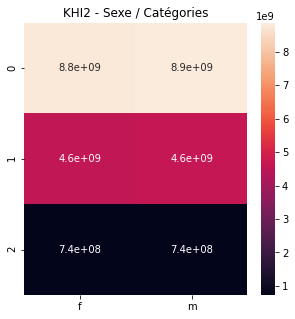

p_value: 1.0
Chi-2: 1.9333027953172328e-23


In [6]:
## représentation du khi2 en forme de figure
plt.figure(figsize=(5,5))
plt.title("KHI2 - Sexe / Catégories")
plt.xlabel("sexe")
plt.ylabel("Catégories", fontsize=12)
sns.heatmap(indep, annot=True)
plt.show()
print("p_value:", round(p_value, 20))
print("Chi-2:", chi2)

## PARTIE II - Y a-t-il une corrélation entre l'âge des clients : ?

In [7]:
cpForClientSpend = data.copy()
cp = data.copy()
cp = cp.drop_duplicates()
cp = cp.loc[cp['sell_year'] == 2021]
cpForClientSpend = cpForClientSpend.groupby(['client_id']).sum().reset_index()
cpForClientSpend = cpForClientSpend[['client_id','price']]
cpForClientSpend = cpForClientSpend.rename(columns={"price": "spend_annual"}) 
mergeClientSpend = cpForClientSpend.merge(cp, left_on='client_id', right_on='client_id')
mergeClientSpend = mergeClientSpend[['client_id','user_age','spend_annual']]
mergeClientSpend = mergeClientSpend.drop_duplicates()
mergeClientSpend = mergeClientSpend.loc[mergeClientSpend['user_age'] >= 20] 
mergeClientSpend.head(1)

,client_id,user_age,spend_annual
0,c_1,66,300.65


In [8]:
newMergeClientSpend = mergeClientSpend.sort_values(by='spend_annual', ascending=False, na_position='first')
newMergeClientSpend = newMergeClientSpend.loc[newMergeClientSpend['spend_annual'] <= 54441.92]
newMergeClientSpend

,client_id,user_age,spend_annual
251680,c_7959,47,2564.25
128350,c_4491,37,2540.53
254301,c_8026,43,2537.67
48987,c_2140,44,2527.01
266055,c_8392,43,2515.98
...,...,...,...
271134,c_855,70,10.30
264961,c_8351,53,6.31
33500,c_1675,21,5.57
257011,c_8114,59,4.99


# Le montant des achats
</br> <br>
<a id="q2" class="btn btn-default" href="#som"> retour au sommaire </a>

expliquation que de 0.05 des datas 


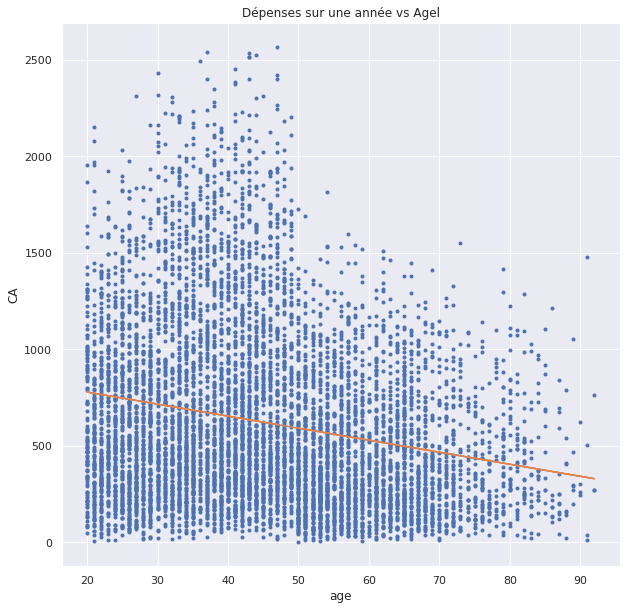

In [9]:
X = newMergeClientSpend['user_age'].values[:,np.newaxis]
# target data is array of shape (n,) 
y = newMergeClientSpend['spend_annual'].values

modelRegressionLinear = LinearRegression()
modelRegressionLinear.fit(X, y)
RCarre = modelRegressionLinear.score(X, y)
sns.set_theme()
sns.set_style("darkgrid")
plt.figure(figsize=(10,10))
plt.plot(X, y, '.')
plt.plot(X, modelRegressionLinear.predict(X))
plt.title("Dépenses sur une année vs Age")
plt.xlabel('age')
plt.ylabel("CA")
plt.plot()
print(f"expliquation que de {RCarre:.2f} des datas ")


# La fréquence d’achat
</br> <br>
<a id="q3" class="btn btn-default" href="#som"> retour au sommaire </a>

In [10]:
cp4 = data.copy()
labels = ['jeune', 'medium-age', 'grand-age']
min_value = cp4['user_age'].min()
max_value = cp4['user_age'].max()
bins = np.linspace(min_value,max_value,4)
cp4['bins'] = pd.cut(cp4['user_age'], bins=bins, labels=labels, include_lowest=True)
cp4.head(1)

,index,client_id,sex,user_birthday,binning_age,user_age,category_id,id_product,price,sell_date,transaction_date,sell_year,month,month_string,traceability_transaction,bins
0,0,c_4410,f,1967,"(50.0, 60.0]",54,0,0_1455,8.99,2021-03-22 14:29:25.189266,2021-03-22,2021,3,Mars,1,medium-age


In [11]:
binningAgeMonth = cp4.groupby(['bins','month']).mean().reset_index()
binningAgeMonth = binningAgeMonth[['bins','month','price']]
binningAgeMonth.head(3)

,bins,month,price
0,jeune,1,19.864649
1,jeune,2,20.653665
2,jeune,3,18.233919


expliquation que de 0.25 des datas 


<ipython-input-12-46be6d79b5f9>:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = binningAgeMonth['bins'].values[:,np.newaxis]


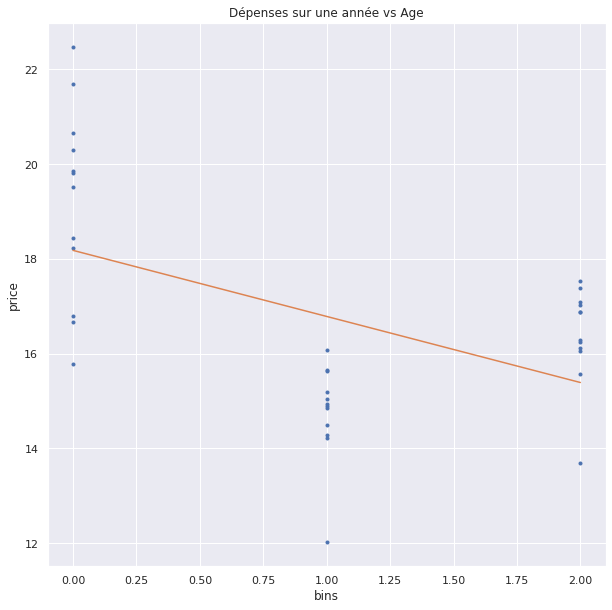

In [12]:
# avec une regression linéaire 

X = binningAgeMonth['bins'].values[:,np.newaxis]
# target data is array of shape (n,) 
y = binningAgeMonth['price'].values

modelRegressionLinear = LinearRegression()
modelRegressionLinear.fit(X, y)
RCarre = modelRegressionLinear.score(X, y)
sns.set_theme()
sns.set_style("darkgrid")
plt.figure(figsize=(10,10))
plt.plot(X, y, '.')
plt.plot(X, modelRegressionLinear.predict(X))
plt.title("Dépenses sur une année vs Age")
plt.xlabel('bins')
plt.ylabel("price")
plt.plot()
print(f"expliquation que de {RCarre:.2f} des datas ")


/usr/local/lib/python3.8/site-packages/pingouin/parametric.py:991: RuntimeWarning: invalid value encountered in double_scalars
  mserror = sserror / ddof2


Rapport de corrélation: 0    1.0
Name: n2, dtype: float64


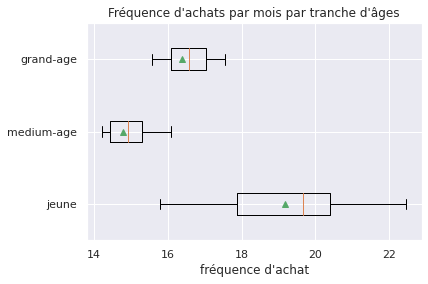

In [13]:
dic = {}

for i in binningAgeMonth.bins.unique():
    dic[i] = list(binningAgeMonth.loc[binningAgeMonth.bins == i,'price'])

plt.boxplot([
    dic['jeune'],
    dic['medium-age'],
    dic['grand-age']
], vert=False, showmeans=True, showfliers=False)
plt.title("Fréquence d'achats par mois par tranche d'âges")
plt.xlabel("fréquence d'achat")
plt.yticks([1,2,3], ['jeune', 'medium-age', 'grand-age'])

import pingouin as pg
eta_carre = binningAgeMonth.anova(dv='month', between='price', detailed=False,
                   effsize='n2')

print("Rapport de corrélation:", eta_carre['n2'])

# La taille du panier moyen
</br> <br>
<a id="q4" class="btn btn-default" href="#som"> retour au sommaire </a>

expliquation que de 0.30 des datas. Coéficient de pearson : -0.55


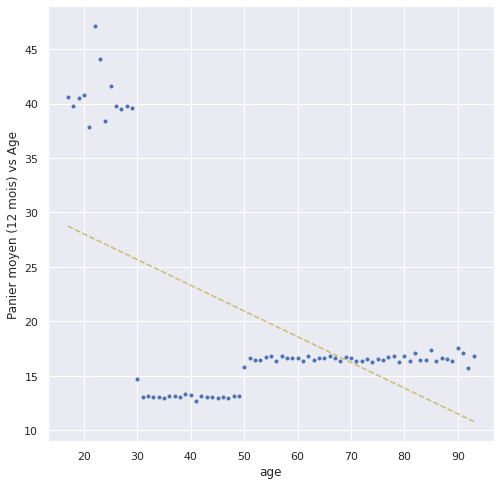

In [14]:
cp3 = data.copy()
binningCategory = cp3.groupby(['binning_age','category_id']).sum()
binningCategory
binningCategory = binningCategory[['price']].reset_index()
from sklearn.linear_model import LinearRegression

meanByAge = data.groupby(['user_age']).mean()
meanByAge = meanByAge.reset_index()
meanByAge = meanByAge[['user_age','price']] 

X = meanByAge['user_age'].values[:,np.newaxis]
# target data is array of shape (n,) 
y = meanByAge['price'].values

modelLinearPanierMoyAge = LinearRegression()
modelLinearPanierMoyAge.fit(X, y)

RCarre = modelLinearPanierMoyAge.score(X, y)

sns.set_theme()
sns.set_style("darkgrid")

pearson = ss.stats.pearsonr(meanByAge['user_age'],meanByAge['price'])

#sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
plt.figure(figsize=(8,8))
plt.plot(X, y, '.')
plt.plot(X, modelLinearPanierMoyAge.predict(X), 'y--')
plt.xlabel('age')
plt.ylabel("Panier moyen (12 mois) vs Age")
plt.plot()
print(f"expliquation que de {RCarre:.2f} des datas. Coéficient de pearson : {pearson[0]:.2f}")

# Les catégories de produits achetés
</br> <br>
<a id="q5" class="btn btn-default" href="#som"> retour au sommaire </a>

In [15]:
cp5 = data.copy()
labels = ['jeune', 'medium-age', 'grand-age']
min_value = cp5['user_age'].min()
max_value = cp5['user_age'].max()
bins = np.linspace(min_value,max_value,4)
cp5['bins'] = pd.cut(cp5['user_age'], bins=bins, labels=labels, include_lowest=True)
cp5 = cp5[['category_id','bins']]
cp5

,category_id,bins
0,0,medium-age
1,0,jeune
2,0,medium-age
3,0,jeune
4,0,jeune
...,...,...
336708,2,jeune
336709,2,jeune
336710,0,jeune
336711,0,jeune


In [16]:
catBinning = cp5[["category_id", "bins"]].pivot_table(index="category_id",
                              columns="bins",
                              aggfunc=len)
catBinning

bins,jeune,medium-age,grand-age
category_id,,,
0,117507,83202,8717
1,46196,52698,10841
2,16528,863,161


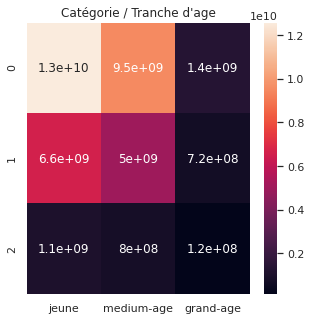

p_value: 1.0
Etat carré 0    0.004445
Name: n2, dtype: float64


In [17]:
contingence =  catBinning.copy()
catNp = cp5["category_id"].value_counts()
binsNp = cp5["bins"].value_counts()

catNp = pd.DataFrame(catNp)
binsNp = pd.DataFrame(binsNp)

catNp.columns=["foo"]
binsNp.columns=["foo"]
n = len(contingence)
indep =  catNp.dot(binsNp.T)/n

indep.sort_index(axis=1, inplace=True)
indep.sort_index(inplace=True)

import pingouin as pg
anovaCalculation = cp5.anova(dv='category_id', between='bins', detailed=False,
                   effsize='n2')



plt.figure(figsize=(5,5))
plt.title("Catégorie / Tranche d'age")
plt.xlabel("Tranche d'age ")
plt.ylabel("Catégories", fontsize=12)
sns.heatmap(indep, annot=True)
plt.show()
print("p_value:", round(p_value, 20))
print("Etat carré", anovaCalculation['n2'])

## BONUS Tranches d'âges et montant des achats
<a id="bonus" class="btn btn-default" href="#som"> retour au sommaire </a>

In [18]:
agePrice = data.copy()
agePrice = agePrice[['user_age','price']]
agePrice.head(n)

,user_age,price
0,54,8.99
1,37,8.99
2,45,8.99


([<matplotlib.axis.YTick at 0x7f9ea3f74df0>,
 [Text(0, 1, 'jeune'), Text(0, 2, 'medium-age'), Text(0, 3, 'grand-age')])

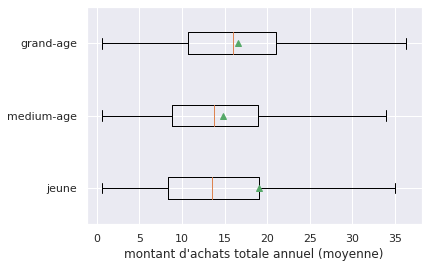

In [19]:
labels = ['jeune', 'medium-age', 'grand-age']
min_value = agePrice['user_age'].min()
max_value = agePrice['user_age'].max()
bins = np.linspace(min_value,max_value,4)
agePrice['bins'] = pd.cut(agePrice['user_age'], bins=bins, labels=labels, include_lowest=True)


dic = {}

for i in agePrice.bins.unique():
    dic[i] = list(agePrice.loc[agePrice.bins == i,'price'])


plt.boxplot([
    dic['jeune'],
    dic['medium-age'],
    dic['grand-age']
], vert=False, showmeans=True, showfliers=False)

plt.xlabel("montant d'achats totale annuel (moyenne)")
plt.yticks([1,2,3], ['jeune', 'medium-age', 'grand-age'])
